In [1]:
from pathlib import Path

import torch
import torch.nn as nn
import numpy as np
import torchxai.model as xaim
from src.models import resnet
from src.utils import *
from src.trainsettings import ModelTranier

In [19]:
from src.utils import argument_parsing, Explorer

mnist_parser = argument_parsing(preparse=True)
mnist_args_string = \
"""-pp  ../XAI
-dp  ../data
-rf  mnist-resnetsmall-roar-eval
-dt  mnist
-et  roar
-at  random  vanillagrad  inputgrad  guidedgrad  gradcam
-mt  resnet
-bs  256
-ns  10
-down""".replace("\n", "  ").split("  ")
mnist_args = mnist_parser.parse_args(mnist_args_string)

cifar10_parser = argument_parsing(preparse=True)
cifar10_args_string = \
"""-pp  ../XAI
-dp  ../data
-rf  cifar10-resnetsmall-roar-eval
-dt  cifar10
-et  roar
-at  random  vanillagrad  inputgrad  guidedgrad  gradcam
-mt  resnet
-bs  256
-ns  30
-down""".replace("\n", "  ").split("  ")
cifar10_args = cifar10_parser.parse_args(cifar10_args_string)

In [23]:
trainer = ModelTranier()
_, test_dataset, *_ = trainer.build_dataset(args)

# [XAI Tutorial 01] with MNIST / CIFAR10 (To be updated)

## Contents

1. XAI
2. Interpretability 
    - What is Interpretability
    - Why Interpretability
    - Types of Interpretability
3. Deep Neural Network Interpretability
    - Interpreting Models
        - Representation Analysis
        - Data Generation
        - Example-based
    - Interpreting Descions
        - Example-based
        - Attribution Methods
4. Evaluation Attribution Methods
    - Qualitative
        - Coherence
        - Class Sensitivity
    - Quantitative
        - Selectivity
        - ROAR / KAR

---

# Evaluation of Attribution Methods - Quantitative

## Selectivity

Sensitivity 의 과정: 

1. attribution method 로 평가한다.
2. 최고 높은 attribution 픽셀을 지운다.
3. 다시 입력으로 해서 평가한다.


## ROAR

https://arxiv.org/abs/1806.10758

What would happen without re-training? 

The re-training is the most computationally expensive aspect of ROAR. One should question whether it is actually needed. We argue that re-training is needed because machine learning models **typically assume that the train and the test data comes from a similar distribution.**

The replacement value c can only be considered uninformative if the model is trained to learn it as such. Without retraining, it is unclear whether degradation in performance is **due to the introduction of artifacts outside of the original training distribution** or **because we actually removed information**. This is made explicit in our experiment in Section 4.3.1, we show that without retraining the degradation is far higher than the modest decrease in performance observed with re-training. This suggests retraining has better controlled for artefacts introduced by the modification.


ROAR 의 프로세스:

1. 첫번째 모델을 훈련 시킨다.
2. attribution method 로 평가를 한다(accuracy 측정).
3. 입력에 대한 attribution을 랭킹으로 세고 10%씩 차례차례 지운다.
4. 지운 데이터를 기반으로 다시 훈련시킨다(accuracy 측정).
5. 2~4 과정을 반복한다.

In [55]:
with (args["project_path"] / "trainlog" / "mnist-roar-record.txt").open() as f:
    x = f.read().splitlines()[2:]
    estimate_score = {"lrp": [], "gradinput": []}
    for l in x:
        splited_l = l.strip("|").split("|")
        if splited_l[2] == "lrp":
            estimate_score["lrp"].append(float(splited_l[-1].strip("%")))
        else:
            estimate_score["gradinput"].append(float(splited_l[-1].strip("%")))

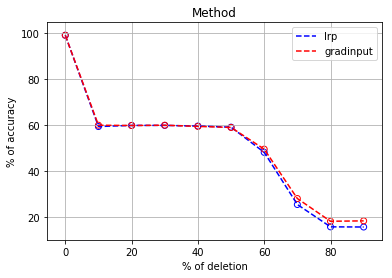

In [56]:
fig, ax = plt.subplots(1, 1)
xx = list(range(0, 100, 10))
ax.plot(xx, estimate_score["lrp"], "b--", label="lrp")
ax.scatter(xx, estimate_score["lrp"], facecolor="none", edgecolor="b")
ax.plot(xx, estimate_score["gradinput"], "r--", label="gradinput")
ax.scatter(xx, estimate_score["gradinput"], facecolor="none", edgecolor="r")
ax.legend()
ax.grid(True)
ax.set_xlabel("% of deletion")
ax.set_ylabel("% of accuracy")
ax.set_title("Method")
plt.show()

In [58]:
gradinput_masks = torch.load(args["project_path"] / args["sv_folder"] / "roar" / "gradinput" / "cnn-relu.masks")
lrp_masks = torch.load(args["project_path"] / args["sv_folder"] / "roar" / "lrp" / "cnn-relu.masks")

In [59]:
def deleted_load_model(model_type, activation_type, attr, del_p):
    path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / "roar" / f"{attr}" / f"{del_p}-cnn-relu.pt")
    model = MNISTmodel(model_type, activation_type)
    load_path = path_finder(attr, str(del_p))
    model.load_state_dict(torch.load(load_path, map_location="cpu"))
    return model

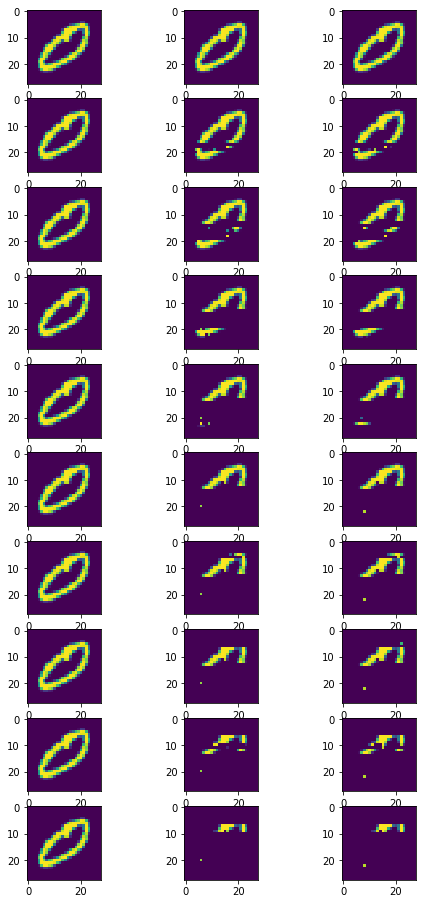

In [60]:
rnd_idx = torch.randint(0, test_dataset.data.size(0), size=(1, ))
img = test_dataset.data[rnd_idx]
# gradinput_mask = gradinput_masks[rnd_idx]
# lrp_mask = lrp_masks[rnd_idx]
delete_percentages = [round(x.item(), 2) for x in torch.arange(0, 1, 0.1)]
fig, axes = plt.subplots(10, 3, figsize=(8, 16))
for row_ax, del_p in zip(axes, delete_percentages):
    row_ax[0].imshow(img.squeeze())
    row_ax[1].imshow(img.squeeze() * lrp_masks[del_p][rnd_idx].eq(0).squeeze())
    row_ax[2].imshow(img.squeeze() * gradinput_masks[del_p][rnd_idx].eq(0).squeeze())

In [73]:
path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / f"{attr}" / f"{rel_p}-cnn-relu.pt")
model = MNISTmodel(model_type, activation_type)
load_path = path_finder("lrp", str(rel_p))
model.load_state_dict(torch.load(load_path, map_location="cpu"))

In [86]:
preds = model_predict(model, imgs)

In [92]:
attr_model = GradInput(model)
outputs = attr_model.get_attribution(imgs, labels)

In [229]:
B, C, H, W = outputs.size()
argmax_v = outputs.view(B, C, -1).argmax(-1)
row_max = argmax_v // W
col_max = argmax_v % W
max_indices = torch.cat([row_max, col_max], dim=-1)

In [44]:
path_finder = lambda attr, rel_p: str(args["project_path"] / args["sv_folder"] / "roar" / f"{attr}" / f"{rel_p}-cnn-relu.pt")
model = MNISTmodel(model_type, activation_type)
load_path = path_finder("lrp", str(0.1))
model.load_state_dict(torch.load(load_path, map_location="cpu"))

*_, test_loader = build_dataset(str(args["root"]), 5)
for data, target in test_loader:
    output = model(data)
    
    pred = output.argmax(dim=1, keepdim=True)
    
    break
#     correct += pred.eq(target.view_as(pred)).sum().item()

In [45]:
target

tensor([6, 1, 8, 1, 2])

In [46]:
pred

tensor([[6],
        [6],
        [2],
        [6],
        [2]])